In [1]:
import os
import numpy as np
import matplotlib.image as mpimg
import tensorflow as tf


def load_dataset(image_dir, gt_dir, target_size=(256, 256)):
    image_files = sorted([f for f in os.listdir(image_dir) if not f.startswith('.')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if not f.startswith('.')])
    
    images = []
    annotations = []
    
    for fname in image_files:
        image_path = os.path.join(image_dir, fname)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32) / 255.0
        images.append(image.numpy())

    for fname in gt_files:
        gt_path = os.path.join(gt_dir, fname)
        annotation = tf.io.read_file(gt_path)
        annotation = tf.image.decode_image(annotation, channels=1)
        annotation = tf.image.resize(annotation, target_size)
        annotation = tf.cast(annotation, tf.float32) / 255.0
        annotations.append(annotation.numpy())
    
    return images, annotations

def convert_rgba_to_binary_mask(annotations):
    binary_masks = [np.where(annotation > 0.5, 1, 0) for annotation in annotations]
    return binary_masks

TRAIN_IMAGE_DIR = "Data/Training/Images"
TRAIN_GT_DIR = "Data/Training/GT"
TEST_IMAGE_DIR = "Data/Testing/Images"
TEST_GT_DIR = "Data/Testing/GT"

train_images, train_annotations = load_dataset(TRAIN_IMAGE_DIR, TRAIN_GT_DIR)
train_masks = convert_rgba_to_binary_mask(train_annotations)
test_images, test_annotations = load_dataset(TEST_IMAGE_DIR, TEST_GT_DIR)
test_masks = convert_rgba_to_binary_mask(test_annotations)



In [2]:
from tensorflow.keras.models import load_model

# Specify the path where the model was saved
model1 = "model1.h5"

# Load the model
model = load_model(model1)



1/1 [==============================] - 1s 1s/step


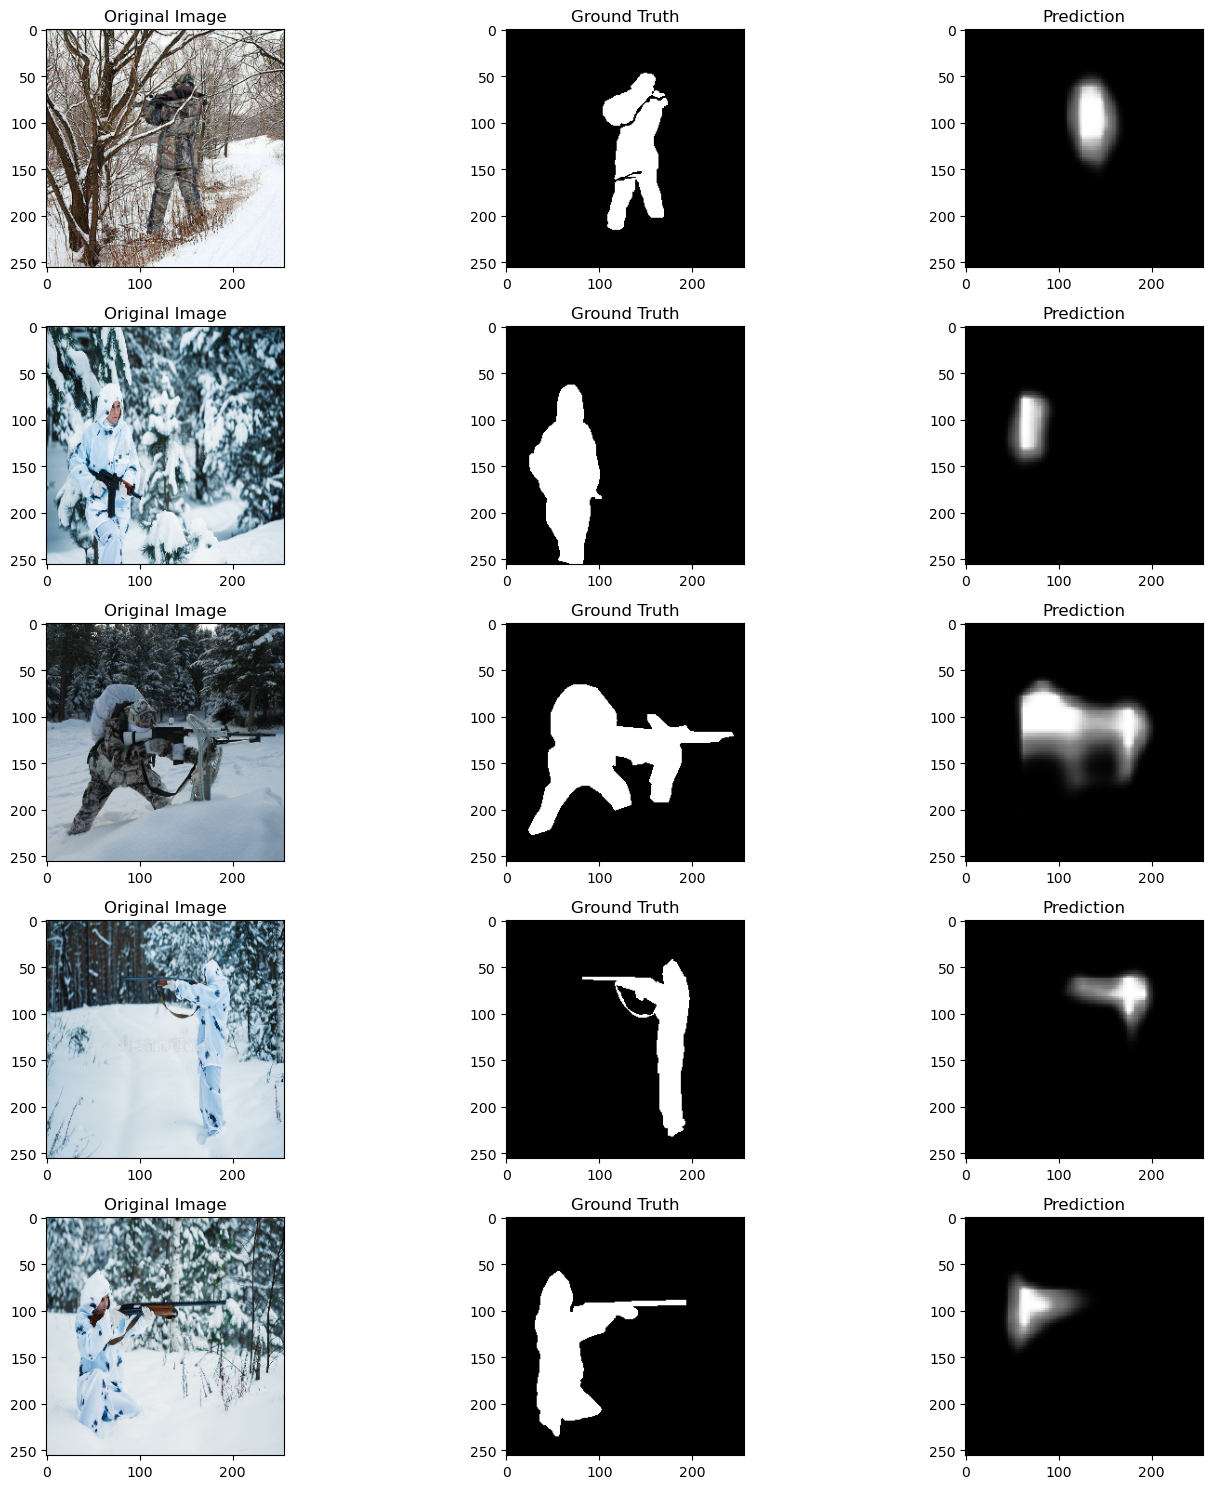

In [3]:
import matplotlib.pyplot as plt

# Predict on a subset of the test dataset
num_samples = 5
predictions = model.predict(np.array(test_images[:num_samples]))

# Display the test images, ground truth masks, and predicted masks
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 15))

for i in range(num_samples):
    axes[i, 0].imshow(test_images[i])
    axes[i, 0].set_title('Original Image')
    
    axes[i, 1].imshow(test_masks[i], cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    
    axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Prediction')

plt.tight_layout()
plt.show()


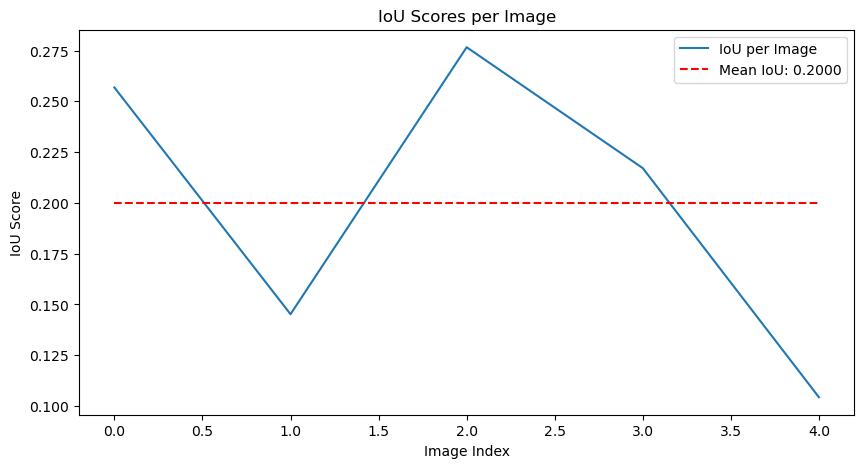

Mean IOU of the select images:  0.20001362648745452


In [4]:
def compute_iou(y_true, y_pred):
    # Convert prediction to binary format based on a threshold (e.g., 0.5)
    y_pred = (y_pred > 0.5).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / union if union != 0 else 0  # Avoid division by zero
    return iou

# Compute IoU for each pair of true mask and predicted mask
ious = [compute_iou(true_mask, pred_mask) for true_mask, pred_mask in zip(test_masks, predictions)]

# Calculate the mean IoU across all images
mean_iou = np.mean(ious)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(ious, label='IoU per Image')
plt.hlines(mean_iou, 0, len(ious)-1, colors='red', linestyles='dashed', label=f'Mean IoU: {mean_iou:.4f}')
plt.xlabel('Image Index')
plt.ylabel('IoU Score')
plt.title('IoU Scores per Image')
plt.legend()
plt.show()

print('Mean IOU of the select images: ',mean_iou)


1/1 [==============================] - 0s 469ms/step


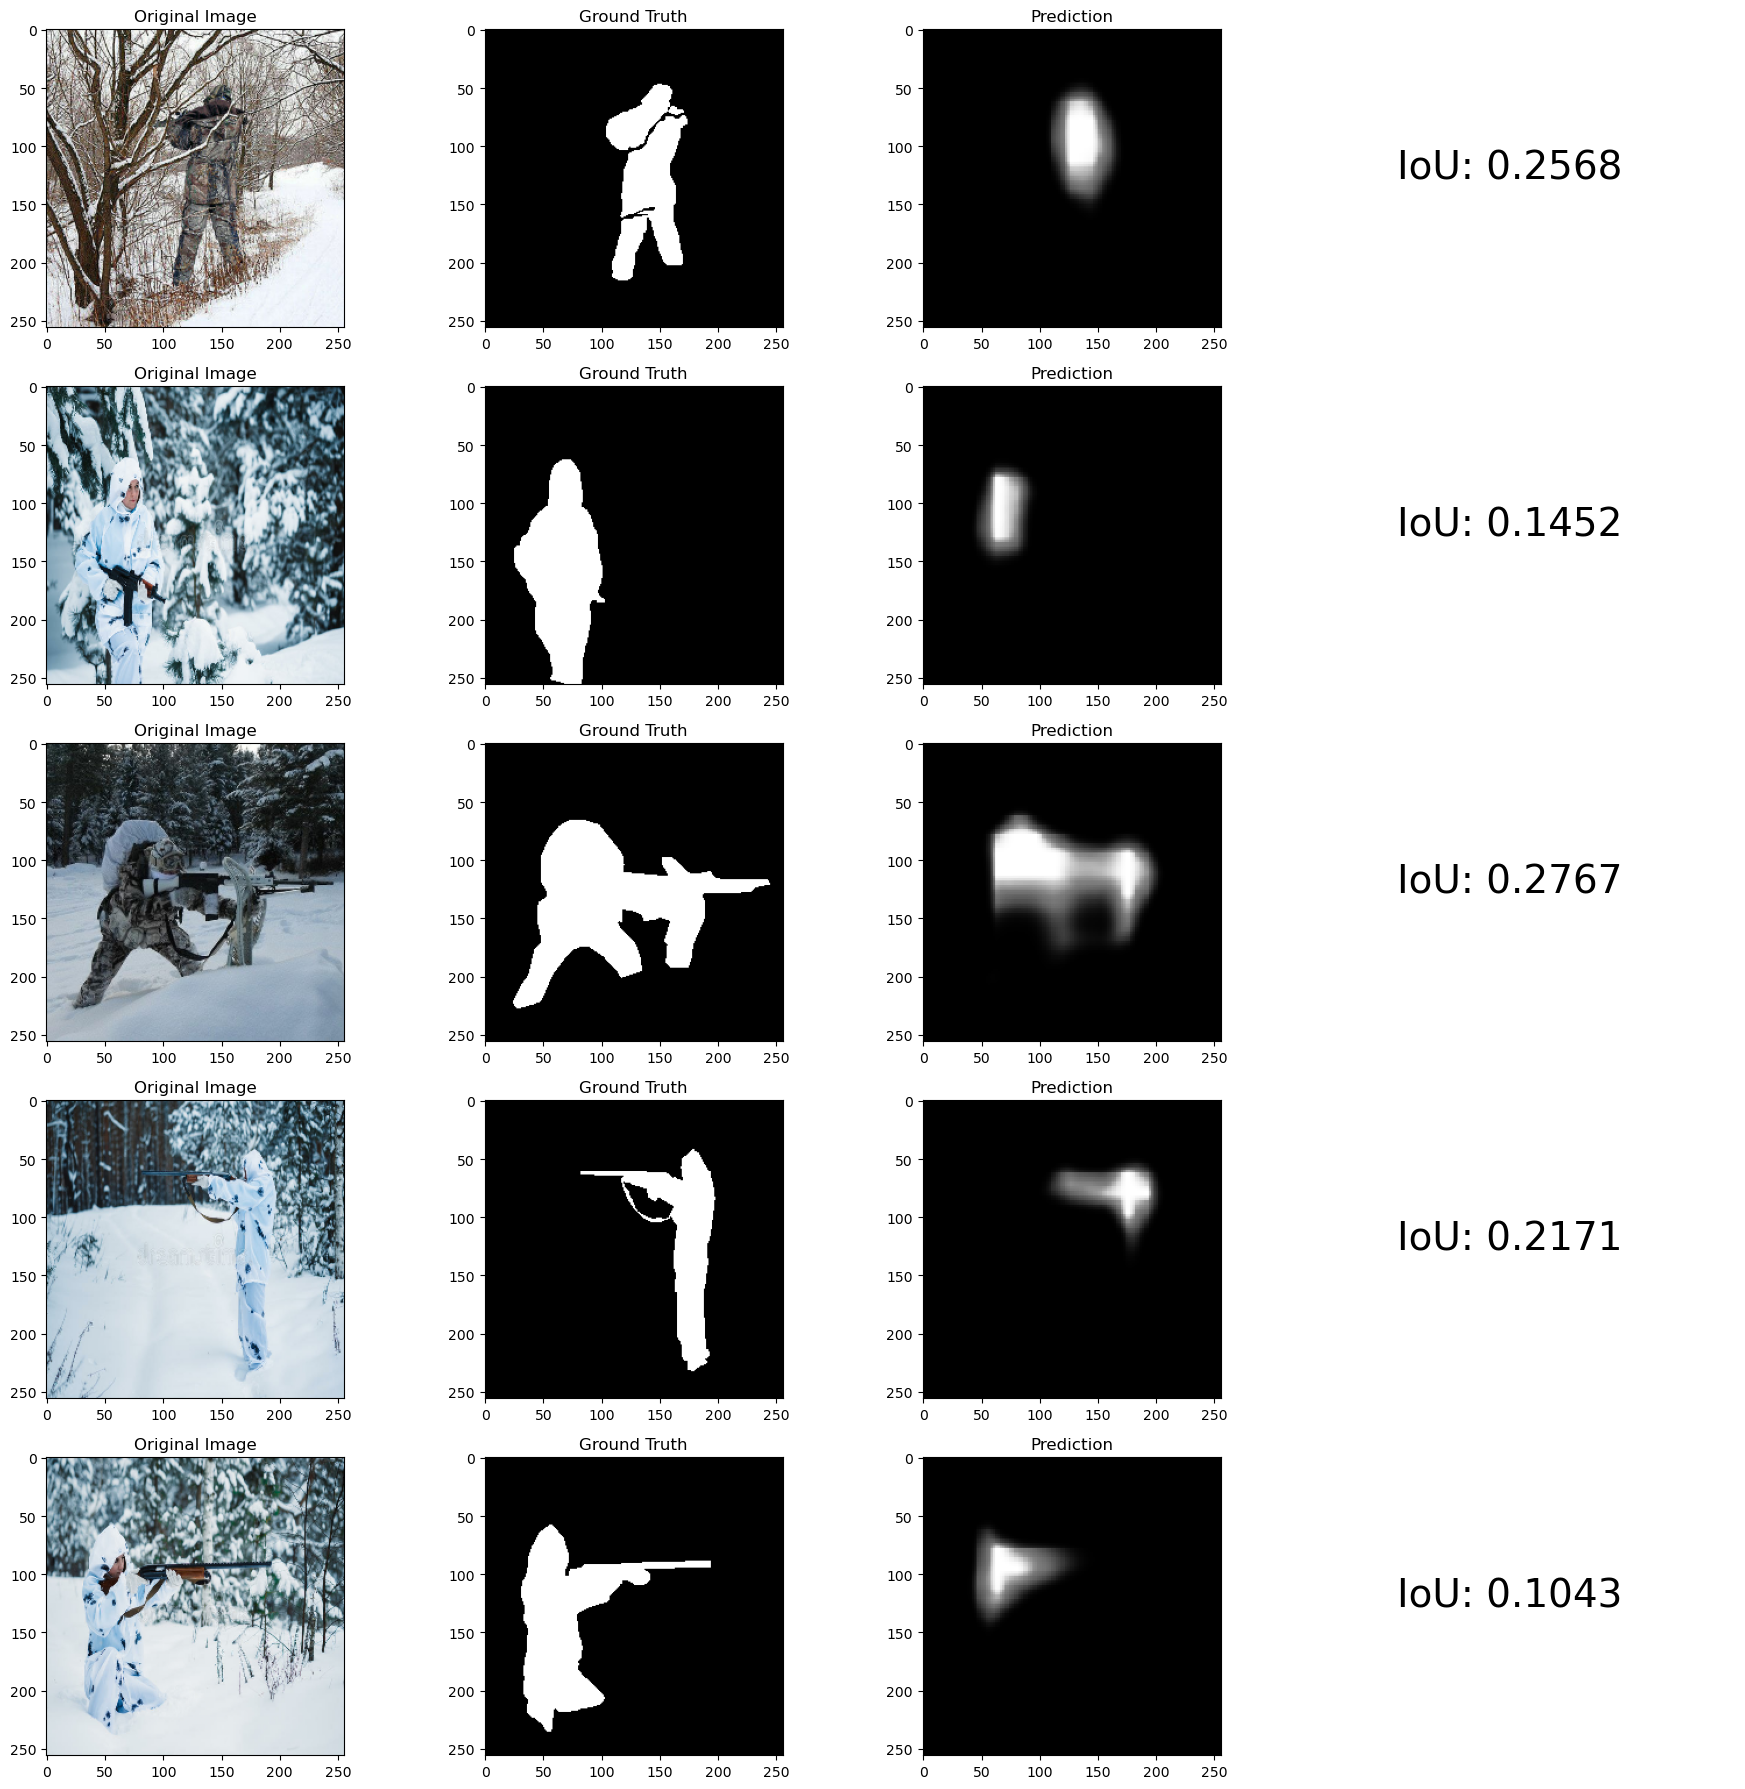

In [5]:
import matplotlib.pyplot as plt

# Predict on a subset of the test dataset
num_samples = 5
predictions = model.predict(np.array(test_images[:num_samples]))

# Calculate IoU scores
ious = [compute_iou(test_masks[i], predictions[i]) for i in range(num_samples)]

# Display the test images, ground truth masks, predicted masks, and IoU scores
fig, axes = plt.subplots(num_samples, 4, figsize=(18, 18))

for i in range(num_samples):
    axes[i, 0].imshow(test_images[i])
    axes[i, 0].set_title('Original Image')
    
    axes[i, 1].imshow(test_masks[i], cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    
    axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Prediction')
    
    # Display IoU score alongside the images
    axes[i, 3].text(0.5, 0.5, f'IoU: {ious[i]:.4f}', fontsize=28, ha='center')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 603ms/step


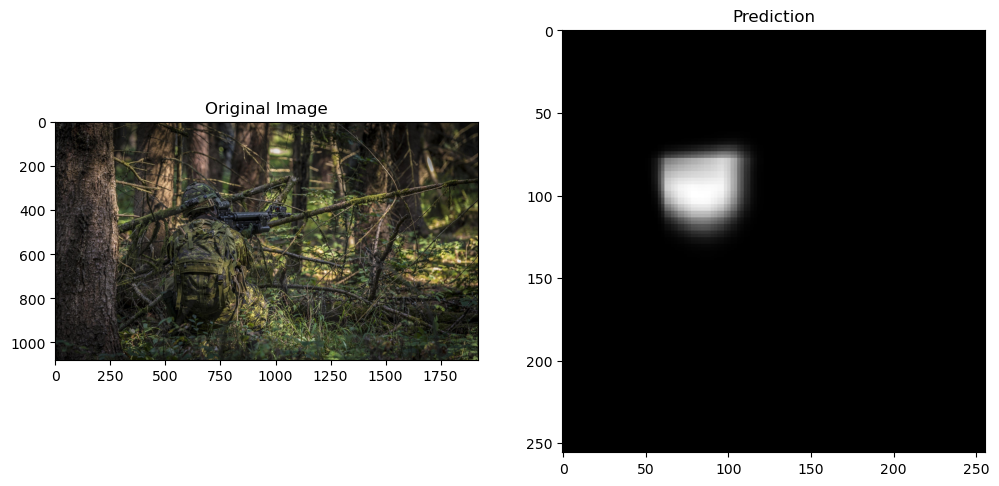

1/1 [==============================] - 0s 95ms/step


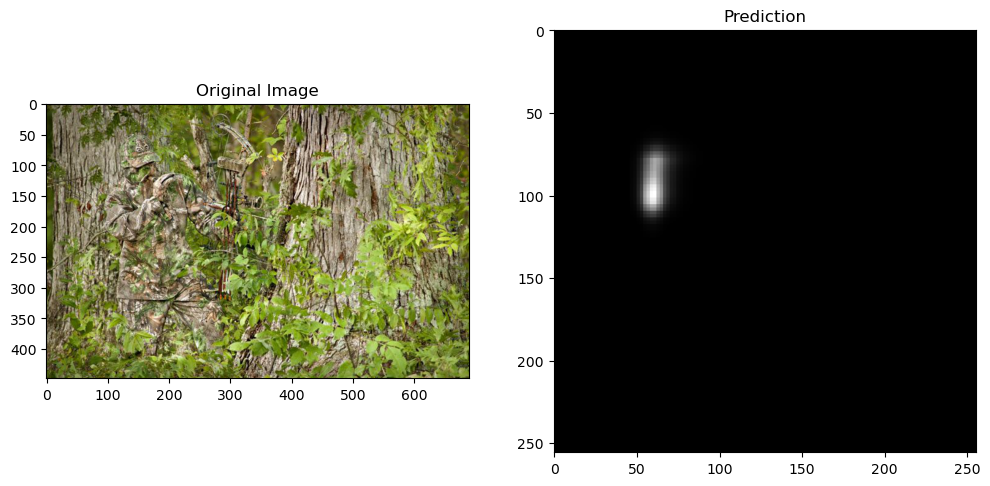

1/1 [==============================] - 0s 95ms/step


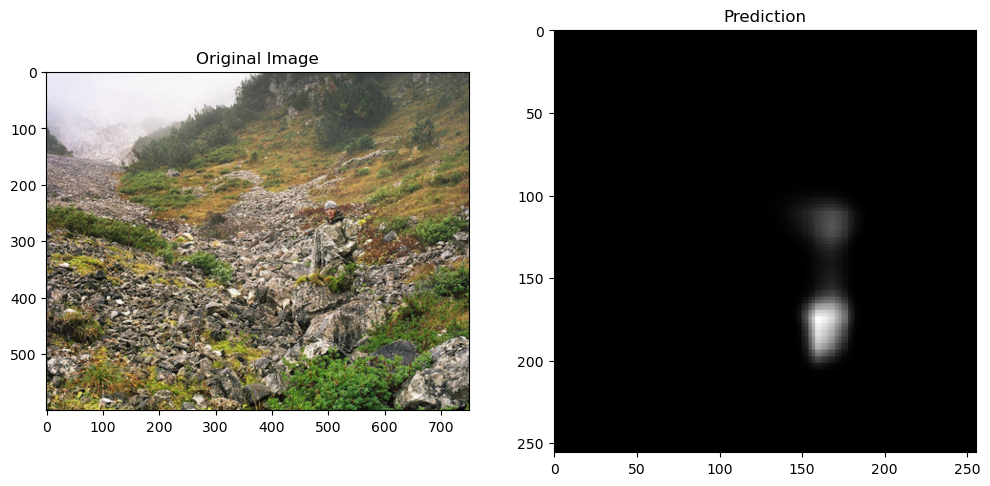

1/1 [==============================] - 0s 107ms/step


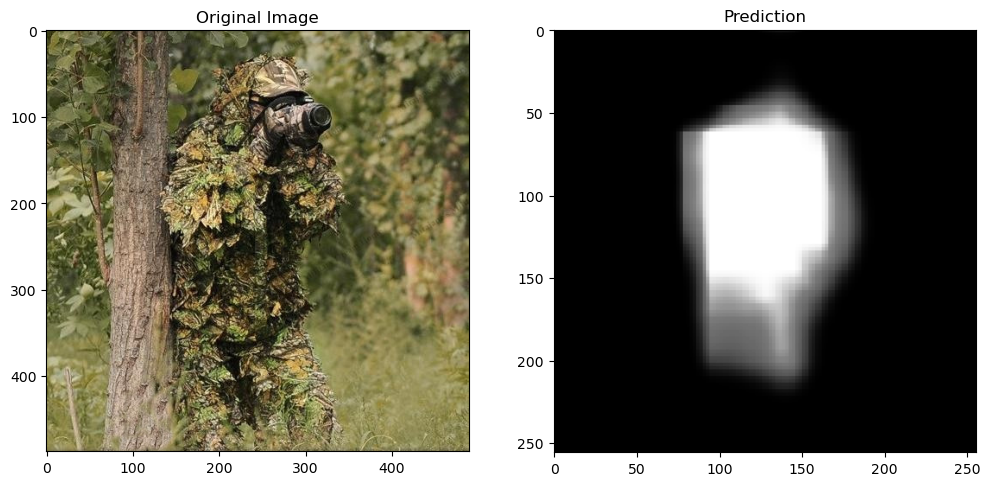

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
import os  # To list directory contents

# Define the path to the saved model and the directory containing images
model_path = 'model1.h5'  # Replace with your actual model path if different
image_dir = 'Trial'  # Replace with your actual image directory if different

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    input_image = load_img(image_path, target_size=(256, 256))  # Resize to the input size expected by the model
    input_image = img_to_array(input_image)  # Convert to array
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = input_image / 255.0  # Scale pixel values to [0, 1]
    return input_image

# Iterate over all images in the directory
for filename in os.listdir(image_dir):
    # Construct the full path to the image
    file_path = os.path.join(image_dir, filename)
    if os.path.isfile(file_path):
        # Load and preprocess the image
        input_image = load_and_preprocess_image(file_path)
        
        # Predict using the model
        predictions = model.predict(input_image)
        
        # Visualize the image and the prediction
        plt.figure(figsize=(12, 6))

        # Show the original image
        original_image = plt.imread(file_path)
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')

        # Show the prediction (assuming single-channel output)
        # Adjust this if your prediction includes more channels or is not image-like
        plt.subplot(1, 2, 2)
        plt.imshow(predictions[0, :, :, 0], cmap='gray')
        plt.title('Prediction')

        # Display the plot
        plt.show()


In [7]:
import gradio as gr
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

# Load the trained model
model = load_model('model1.h5')  # Make sure 'model1.h5' is the correct path to your model

# Prediction function for the Gradio app
def predict_and_visualize(img):
    # Store the original image size
    original_size = img.size
    
    # Convert the input image to the target size expected by the model
    img_resized = img.resize((256, 256))
    img_array = np.array(img_resized) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(img_array)
    
    # Assuming the model outputs a single-channel image, normalize to 0-255 range for display
    predicted_mask = (prediction[0, :, :, 0] * 255).astype(np.uint8)
    
    # Convert the prediction to a PIL image
    prediction_image = Image.fromarray(predicted_mask, mode='L')  # 'L' mode is for grayscale
    
    # Resize the predicted image back to the original image size
    prediction_image = prediction_image.resize(original_size, Image.NEAREST)

    return prediction_image

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_and_visualize,
    inputs=gr.Image(type="pil"),  # We expect a PIL Image
    outputs=gr.Image(type="pil"),  # We will return a PIL Image
    title="MilitarEye: Military Stealth Camouflage Detector",
    description="Please upload an image of a military personnel camouflaged in their surroundings. On the right, the model will attempt to predict the camouflage mask silhouette."
)

# Launch the Gradio app
iface.launch()


c:\Users\alias\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
